<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/main/ResNet_Etapa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.6.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 100

In [4]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if file_name  == 'ResNet50.h5':
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[6]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df



In [5]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '400x']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '400x']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 978
quantidade de dados na base de Treino 786


In [7]:
df_treino.columns

Index(['FikePath', 'Type', 'classes', 'Magnification', 'DataSet'], dtype='object')

In [8]:
df_treino = df_treino.drop(columns=['Magnification','DataSet'])
df_treino.head()

,FikePath,Type,classes
0,/content/drive/MyDrive/TCC/400x_Teste/M//DC238...,M,DC
1,/content/drive/MyDrive/TCC/400x_Teste/M//DC239...,M,DC
2,/content/drive/MyDrive/TCC/400x_Teste/M//DC243...,M,DC
3,/content/drive/MyDrive/TCC/400x_Teste/M//DC244...,M,DC
4,/content/drive/MyDrive/TCC/400x_Teste/M//DC241...,M,DC


In [9]:
df_treino = df_treino[df_treino['Type'] == 'M']

In [10]:
df_treino.head()

,FikePath,Type,classes
0,/content/drive/MyDrive/TCC/400x_Teste/M//DC238...,M,DC
1,/content/drive/MyDrive/TCC/400x_Teste/M//DC239...,M,DC
2,/content/drive/MyDrive/TCC/400x_Teste/M//DC243...,M,DC
3,/content/drive/MyDrive/TCC/400x_Teste/M//DC244...,M,DC
4,/content/drive/MyDrive/TCC/400x_Teste/M//DC241...,M,DC


In [11]:
df_teste = df_teste.drop(columns=['Magnification','DataSet'])
df_teste.head()

,FikePath,Type,classes
786,/content/drive/MyDrive/TCC/400x_treino/M//DC23...,M,DC
787,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC
788,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC
789,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC
790,/content/drive/MyDrive/TCC/400x_treino/M//DC23...,M,DC


In [12]:
df_teste = df_teste[df_teste['Type'] == 'M']

In [13]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 418
quantidade de dados na base de Treino 418


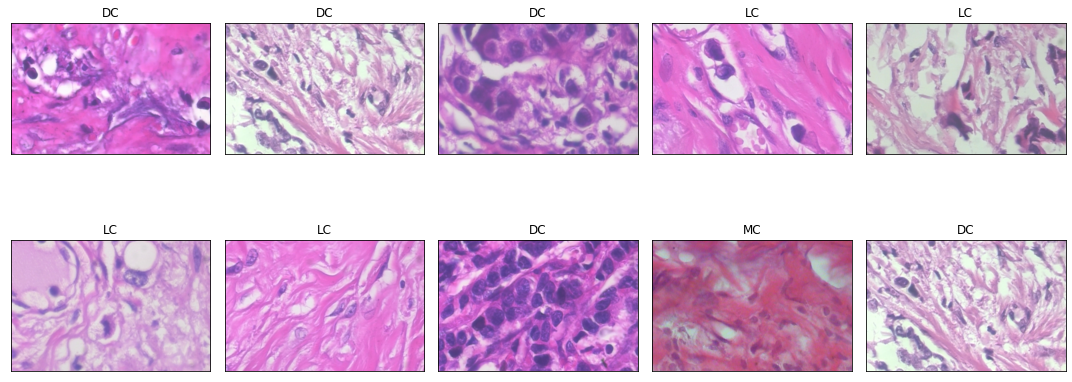

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,400)
    ax.imshow(plt.imread(df_treino.FikePath[ponteiro]))
    ax.set_title(df_treino.classes[ponteiro])
plt.tight_layout()
plt.show()

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)


In [16]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 335 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 418 validated image filenames belonging to 4 classes.


In [18]:
def build_model():
    base_ResNet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
    x = base_ResNet.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs = base_ResNet.input, outputs = preds)
    return model


In [19]:
Resnet = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/ResNet50.h5'
Resnet.load_weights(checkpoint_path)
Resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [22]:
stop = EarlyStopping(monitor='loss', mode='min', patience=50, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)
Resnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [23]:
print("run fit generator")
fit_history = Resnet.evaluate(test_images, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * fit_history[1]))

run fit generator
27/27 - 119s - loss: 1.7122 - accuracy: 0.9258


TypeError: ignored

In [25]:
print("Untrained model, accuracy: {:5.2f}%".format(100 * fit_history[1]))

Untrained model, accuracy: 92.58%


In [29]:
pred = Resnet.predict(test_images)
pred=np.argmax(pred,axis=1)

In [30]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9258373205741627


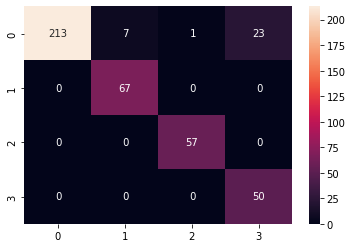

In [31]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d');

,FikePath,Type,classes,pred
786,/content/drive/MyDrive/TCC/400x_treino/M//DC23...,M,DC,DC
787,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC,DC
788,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC,DC
789,/content/drive/MyDrive/TCC/400x_treino/M//DC24...,M,DC,DC
790,/content/drive/MyDrive/TCC/400x_treino/M//DC23...,M,DC,DC
...,...,...,...,...
1199,/content/drive/MyDrive/TCC/400x_treino/M//PC64...,M,PC,PC
1200,/content/drive/MyDrive/TCC/400x_treino/M//PC64...,M,PC,PC
1201,/content/drive/MyDrive/TCC/400x_treino/M//PC64...,M,PC,PC
1202,/content/drive/MyDrive/TCC/400x_treino/M//PC65...,M,PC,PC


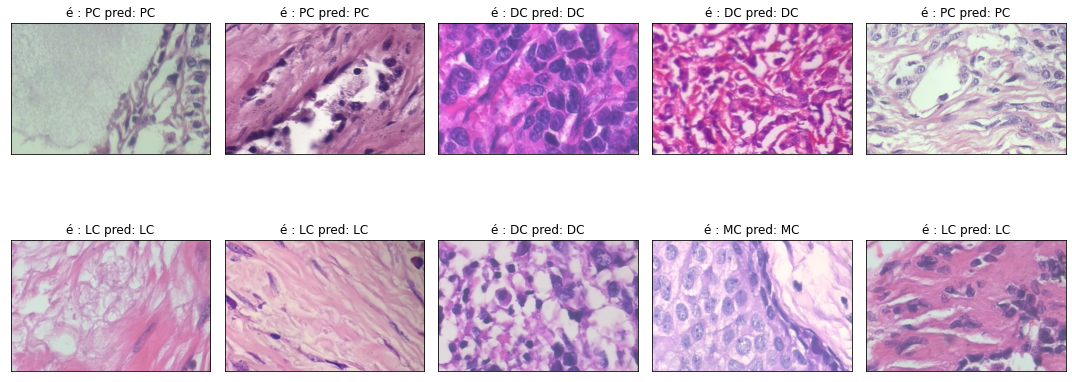

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,400)
    ax.imshow(plt.imread(list(test.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.classes)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()